In [2]:
# Ours
from characters_real_names import *

# Modules
import pylab
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from community import community_louvain as louvain
from netwulf import visualize

import requests
import re

import time
import math

# ---
# Spacy setup
# python -m spacy download en

import spacy

from spacy.tokens import Span
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

# Used to get the gender and distinct people with same family noun. 

def get_person_title(span):
    if span.label_ == "PERSON" and span.start != 0:
        prev_token = span.doc[span.start - 1]
        if prev_token.text in ("Mr", "Mr.", "Mrs", "Mrs."):
            return prev_token.text + " "
    return ""
            

Span.set_extension("person_title", getter=get_person_title, force=True)

# ---
# Get the book text data

book = open("./Harry Potter and the Sorcerer.txt").read()

book_chapters = re.split(r'CHAPTER [\w+]+', book, flags=re.IGNORECASE)[1:]
book_chapters[-1] = book_chapters[-1].split("THE END")[0]

# displacy.serve(nlp(book), style="ent")

In [3]:
# ---
# Cleaning and tokenization

book_chapters_paragraphs = dict()
real_charachers_by_paragraphs = list()

for i, chapter in enumerate(book_chapters):

    # Split and clean up each paragraphs
    paragraphs = chapter.split('\n\n')
    
    for paragraph in paragraphs:
        clean_paragraph = re.sub(r"[\"\;\:\s]+", ' ', paragraph)

        # Tag and detect every person's name by paragraph
        tokens = nlp(clean_paragraph)
        paragraph_persons = [(ent._.person_title + ent.text) for ent in tokens.ents if ent.label_ == "PERSON"]

        # Correct all possible mentions of a person
        # And remove false positive

        real_paragraph_persons = []
        for person in paragraph_persons:
            if person in persons_real_names: real_paragraph_persons.append(person)
            else: 
                for check, replace in name_to_replace.items():
                    reg = re.compile(check, )
                    if reg.match(person): 
                        real_paragraph_persons.append(replace)
                        break
        
        real_charachers_by_paragraphs.append(set(real_paragraph_persons))
        

    book_chapters_paragraphs[i] = paragraphs

In [4]:
# ---
# Graph Filling
# Add edge between 2 characters of the same paragraph
graph = nx.Graph()

for unique_paragraph_persons in real_charachers_by_paragraphs: 
    if len(unique_paragraph_persons) < 2 : continue
    graph.add_nodes_from(unique_paragraph_persons)
    unique = list(unique_paragraph_persons)
    for idx in range(len(unique)-1):
        edge = graph.get_edge_data(unique[idx], unique[idx-1])
        if edge is not None : graph[unique[idx]][unique[idx-1]]['weight'] += 1
        else : graph.add_edge(unique[idx], unique[idx-1], weight=1)

list_edges = list(graph.edges())
list_nodes = list(graph.nodes())

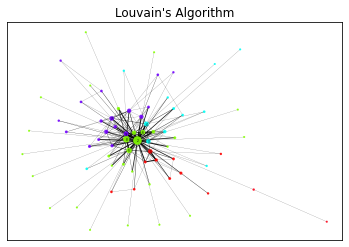

{'Dudley Dursley': 1,
 'Harry Potter': 2,
 'Minerva McGonagall': 3,
 'Albus Dumbledore': 4,
 'Rubeus Hagrid': 5,
 'Quirinus Quirrell': 6,
 'Fred Weasley': 7,
 'Ron Weasley': 8,
 'Draco Malfoy': 9}

In [261]:
# ---
# Louvain Algorithm
# https://github.com/taynaud/python-louvain

# Use mean partition of 100 partitions to smooth
boot_partitions = {}
for _ in range(100): 
    part = louvain.best_partition(graph)
    for k,v in part.items():
        if k in boot_partitions: boot_partitions[k].append(v)
        else: boot_partitions[k] = [v]

partition = {}
for k,v in boot_partitions.items(): partition[k] = round(sum(v) / len(v))

# Get the position of nodes and the colors
pos = nx.spring_layout(graph)
cmap = cm.get_cmap('hsv')

# Tweak size of nodes and width of edges 
node_sizes = [len(list(graph.neighbors(person)))*5+10 for person in graph.nodes]
edge_weights = list(min(v/8, 1) for v in nx.get_edge_attributes(graph,'weight').values())

# Transform names to integer for a better readability
int_names = {}
for i,n in enumerate(partition): 
    if node_sizes[i] >= min(node_sizes)*5: int_names[n] = len(int_names)+1

# Draw the graph
nx.draw_networkx(graph, node_size=node_sizes, cmap=cmap, node_color=list(partition.values()), edge_cmap=cmap, width=edge_weights,labels=int_names, font_size=3, alpha=0.9, linewidths=0.1, node_shape=".")
plt.title("Louvain's Algorithm")
plt.show()

# TODO
# Add a legend mapping the int with names
int_names

In [268]:
# ---
# K-Core decomposition
# Reworked version

def kcore(graph):

    knots, decomposition = {}, {}

    # Using a dictionary
    for person in graph.nodes:
        neighbors = list(graph.neighbors(person))
        knots[person] = {"neighbors": neighbors, "degree": len(neighbors), "pruned": False}

    k, total_pruned = 1, 0

    while total_pruned < len(graph):
        to_prune = [person for person,elems in knots.items() if elems['degree'] == k]
        k_shell = []
        while len(to_prune) > 0:
            x = to_prune.pop(0)
            for n in knots.get(x)['neighbors']:
                v = knots.get(n)
                if not v['pruned']:
                    v['degree'] -= 1
                    if v['degree'] == k : to_prune.append(n)
            knots.get(x)['pruned'] = True
            k_shell.append(x)
            total_pruned += 1
        decomposition[k] = k_shell
        k += 1
    
    return decomposition 

def kcore_order(graph,order):

    new_graph = graph.copy()
    output = kcore(new_graph)
    for i in range(order-1): new_graph.remove_nodes_from(output[i+1])
    return new_graph


def barabasi_albert_generate_graph(graph):
    nb_nodes = len(graph.nodes())
    mean_number_of_edges = round(graph.number_of_edges() / nb_nodes)
    return nx.barabasi_albert_graph(nb_nodes, mean_number_of_edges)

kcore_output = kcore(graph)

# bgraph = gen_barabazi(graph)
# new_graph = order_kcore(bgraph,2)
                

(array([19., 14.,  7., 11.,  4.,  4., 12.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <BarContainer object of 7 artists>)

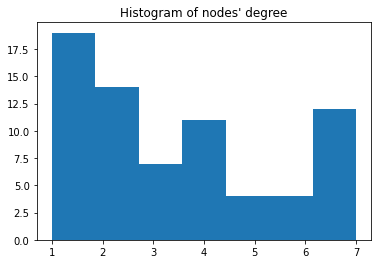

In [7]:
# Draw an histogram of the nodes' degree

kcore_hist = [int(k) for k in kcore_output.keys() for _ in range(len(kcore_output.get(k)))]
plt.title("Histogram of nodes' degree")
plt.hist(kcore_hist, bins=len(kcore_output.keys()))

In [239]:
# ---
# Greedy Implementation of the Influence Maximization Problem
# Implemented by Romain Graux

def generate_active_edges(graph:nx.Graph) -> nx.Graph:

    g = graph.copy()
    edges = g.edges()

    # Probability is proportional to the weight
    edges_proba = np.array([g[u][v].get('weight', 1) for u, v in edges])
    edges_proba = edges_proba / sum(edges_proba)

    # As the instruction does not specify what probability we have to take for the activation of the edges we have chosen to use multinomial experiments.
    activated_edges = np.random.multinomial(len(edges), edges_proba) > 0

    for activated, (u, v, info) in zip(activated_edges, g.edges.data()):
        g[u][v]['activated'] = activated

    return g

def get_accessible_neighbors(g:nx.Graph, node) -> list:
    accessible_neighbors = []
    for neighbor in g.neighbors(node):
        if g[node][neighbor].get('activated', False):
            accessible_neighbors.append(neighbor)
    
    return accessible_neighbors

def get_number_accessible_neighbors(g:nx.Graph, A0:list) -> dict:
    neighbors = A0[:]
    new_neighbors = A0[:]
    while new_neighbors:
        node = new_neighbors.pop()
        new_neighbors += get_accessible_neighbors(g, node)
        new_neighbors = list(set(new_neighbors) - set(neighbors))
        neighbors += new_neighbors


    n = len(neighbors)
    return dict(
        count=n,
        accessible_neighbors=neighbors
    )

def greedy(graph:nx.Graph, k:int, n:int) -> list:
    A0 = []
    graphs = [generate_active_edges(graph) for _ in range(n)]

    for _ in range(k):
        nodes_to_test = list(set(graph.nodes) - set(A0))
        nodes_score = dict(zip(nodes_to_test, [0]*len(nodes_to_test)))
        for node in nodes_to_test:
            for g in graphs:
                accessible_dict = get_number_accessible_neighbors(g, A0+[node])
                nodes_score[node] += accessible_dict.get('count')

        # Retrieve the max
        best_node = max(nodes_score, key=nodes_score.get)
        A0.append(best_node)

    return A0



best 4 nodes with 100 simulations : ['Harry Potter', 'Ron Weasley', 'Vernon Dursley', 'Petunia Dursley']


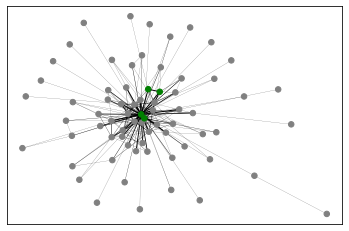

In [313]:
k = round(graph.number_of_nodes() * 0.05)
n = 100

A0 = greedy(graph, k, n)

print(f"Best {k} nodes with {n} simulations : {A0}")

node_colors = ["green" if no in A0 else "gray" for no in graph.nodes]
nx.draw_networkx(graph, node_color=node_colors, node_size=30, labels=int_names, with_labels=False, width=edge_weights)